# NN solution

## Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
from colorama import Fore, Back, Style
from pathlib import Path
import gc

from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import keras_tuner

## Config

In [2]:
MAKE_PCA = True
TUNE_LR = False
TUNE = False
SUBMIT = True

PATH = Path('/kaggle/input/open-problems-multimodal')
COLUMNS_PATH = Path('/kaggle/input/citiseq_important_cols')

RANDOM_STATE = 1
N_COMPONENTS = 64

LR_START = 0.01
BATCH_SIZE = 256
EPOCHS = 1000

MAX_TRIALS = 1
OUTPUT_DIR = '/kaggle/temp'

BEST_HP = {
    'reg1': 9.621776282024844e-06,
    'reg2': 2.9962287056832333e-06,
    'units1': 256,
    'dp0': 0.0,
    'batchnorm0': True,
    'units2': 256,
    'dp1': 0.0,
    'batchnorm1': True,
    'dpfinal': 0.28144863074298754,
    'batchnormfinal': True
}

In [3]:
np.random.seed(1)
tf.random.set_seed(1)

## Competition metric

In [4]:
def correlation_score(y_true, y_pred):
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, y_true.shape[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(y_true.shape[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r


## Prepare data

In [5]:
metadata_df = pd.read_csv(PATH / 'metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology == "citeseq"]

Y = pd.read_hdf(PATH / 'train_cite_targets.h5')
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)

In [6]:
if MAKE_PCA:
    important_cols = np.loadtxt(COLUMNS_PATH / 'important_cols_v0.txt',
                                dtype='str')
    constant_cols = np.loadtxt(COLUMNS_PATH / 'constant_cols.txt', dtype='str')
    print(f"Constant cols: {len(constant_cols)}")

    X = pd.read_hdf(PATH / 'train_cite_inputs.h5').drop(columns=constant_cols)
    meta = metadata_df.reindex(X.index)
    X0 = X[important_cols].values
    X = sparse.csr_matrix(X.values)
    gc.collect()

    X_test = pd.read_hdf(PATH /
                         'test_cite_inputs.h5').drop(columns=constant_cols)
    meta_test = metadata_df.reindex(X_test.index)
    X0_test = X_test[important_cols].values
    X_test = sparse.csr_matrix(X_test.values)

    both = sparse.vstack([X, X_test])
    svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
    both = svd.fit_transform(both)

    X = both[:70988]
    X_test = both[70988:]
    del both
    gc.collect()

    X = np.hstack([X, X0])
    X_test = np.hstack([X_test, X0_test])
    del X0, X0_test
    gc.collect()
else:
    X = np.load(PATH / 'train_115_64.npy')
    X_test = np.load(PATH / 'test_115_64.npy')

Constant cols: 1194


## Model

2023-02-17 01:25:09.006110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-17 01:25:09.006199: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


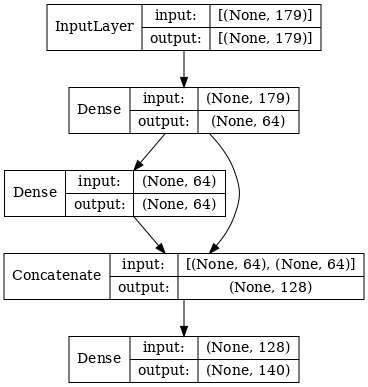

In [7]:
def my_model(hp, n_inputs=X.shape[1]):
    activation = 'swish'
    reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
    reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-5, sampling="log")

    inputs = Input(shape=(n_inputs, ))

    x0 = Dense(
        hp.Choice('units1', [64, 128, 256]),
        kernel_regularizer=tf.keras.regularizers.l2(reg1),
        activation=activation,
    )(inputs)
    dp0 = hp.Float('dp0', min_value=0., max_value=0.5)
    if dp0 > 0:
        x0 = tf.keras.layers.Dropout(dp0)(x0)
    bn0 = hp.Boolean('batchnorm0')
    if bn0:
        x0 = tf.keras.layers.BatchNormalization()(x0)

    x1 = Dense(
        hp.Choice('units2', [64, 128, 256]),
        kernel_regularizer=tf.keras.regularizers.l2(reg1),
        activation=activation,
    )(x0)
    dp1 = hp.Float('dp1', min_value=0., max_value=0.5)
    if dp1 > 0:
        x1 = tf.keras.layers.Dropout(dp1)(x1)
    bn1 = hp.Boolean('batchnorm1')
    if bn1:
        x1 = tf.keras.layers.BatchNormalization()(x1)

    x = Concatenate()([x0, x1])
    dpfinal = hp.Float('dpfinal', min_value=0., max_value=0.5)
    if dpfinal > 0:
        x = tf.keras.layers.Dropout(dpfinal)(x)
    bnfinal = hp.Boolean('batchnormfinal')
    if bnfinal:
        x = tf.keras.layers.BatchNormalization()(x)

    outputs = Dense(Y.shape[1],
                    kernel_regularizer=tf.keras.regularizers.l2(reg2))(x)
    model = Model(inputs, outputs)

    if TUNE_LR:
        learning_rate = hp.Float('learning_rate',
                                 min_value=1e-5,
                                 max_value=1e-1)
    else:
        learning_rate = LR_START

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  metrics=[negative_correlation_loss],
                  loss=negative_correlation_loss)

    return model


display(
    plot_model(my_model(keras_tuner.HyperParameters()),
               show_layer_names=False,
               show_shapes=True,
               dpi=72))

## Keras tuner

In [8]:
def tune_net(X_train, X_val, y_train, y_val):

    lr = ReduceLROnPlateau(monitor="val_loss",
                           factor=0.5,
                           patience=4,
                           verbose=0)

    es = EarlyStopping(monitor="val_loss",
                       patience=8,
                       verbose=0,
                       mode="min",
                       restore_best_weights=False)

    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    tuner = keras_tuner.BayesianOptimization(
        my_model,
        overwrite=False,
        objective=keras_tuner.Objective("val_negative_correlation_loss",
                                        direction="min"),
        max_trials=MAX_TRIALS,
        directory=OUTPUT_DIR,
        seed=RANDOM_STATE)

    tuner.search(X_train,
                 y_train,
                 epochs=1000,
                 validation_data=(X_val, y_val),
                 batch_size=BATCH_SIZE,
                 callbacks=callbacks,
                 verbose=2)
    return tuner

In [9]:
%%time
if TUNE:
    X_train, X_val, y_train, y_val = train_test_split(
        X, Y, test_size=0.2, random_state=RANDOM_STATE)
    tuner = tune_net(X_train, X_val, y_train, y_val)

    tuner.results_summary()
    display(
        pd.DataFrame([hp.values for hp in tuner.get_best_hyperparameters(10)]))
    best_hp = tuner.get_best_hyperparameters(1)[0]

    del X_train, X_val, y_train, y_val

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [10]:
if not TUNE:
    best_hp = keras_tuner.HyperParameters()
    best_hp.values = BEST_HP

## Train

In [11]:
%%time
score_list = []
histories = []
pred_train = np.zeros((Y.shape[0], Y.shape[1]))
kf = GroupKFold(n_splits=3)
for fold, (idx_train, idx_val) in enumerate(kf.split(X, groups=meta.donor)):
    print('#' * 50)
    print(f'##### Fold {fold}')
    print('#' * 50)
    model = None
    X_train = X[idx_train]
    y_train = Y[idx_train]
    X_val = X[idx_val]
    y_val = Y[idx_val]

    lr = ReduceLROnPlateau(monitor="val_loss",
                           factor=0.5,
                           patience=4,
                           verbose=2)
    es = EarlyStopping(monitor="val_loss",
                       patience=12,
                       verbose=0,
                       mode="min",
                       restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    model = my_model(best_hp, X_train.shape[1])
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        epochs=EPOCHS,
                        verbose=1,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    histories.append(history)

    if SUBMIT:
        model.save(f"/kaggle/temp1/model_{fold}")
    y_val_pred = model.predict(X_val, batch_size=len(X_val))
    pred_train[idx_val] = y_val_pred
    corrscore = correlation_score(y_val, y_val_pred)
    score_list.append(corrscore)

    del X_train, y_train, X_val, y_val
    gc.collect()

np.save('oof.npy', pred_train)

##################################################
##### Fold 0
##################################################
Epoch 1/1000
181/181 [==============================] - 5s 18ms/step - loss: -0.8544 - negative_correlation_loss: -0.8617 - val_loss: -0.8714 - val_negative_correlation_loss: -0.8771 - lr: 0.0100
Epoch 2/1000
181/181 [==============================] - 3s 16ms/step - loss: -0.8928 - negative_correlation_loss: -0.8976 - val_loss: -0.8770 - val_negative_correlation_loss: -0.8811 - lr: 0.0100
Epoch 3/1000
181/181 [==============================] - 3s 16ms/step - loss: -0.8945 - negative_correlation_loss: -0.8985 - val_loss: -0.7712 - val_negative_correlation_loss: -0.7752 - lr: 0.0100
Epoch 4/1000
181/181 [==============================] - 3s 16ms/step - loss: -0.8952 - negative_correlation_loss: -0.8991 - val_loss: -0.8795 - val_negative_correlation_loss: -0.8834 - lr: 0.0100
Epoch 5/1000
181/181 [==============================] - 3s 17ms/step - loss: -0.8953 - negative_corre

## Results

In [12]:
for fold in range(len(score_list)):
    print(f"{Fore.BLACK}{Style.BRIGHT}Fold {fold} Correlation: {score_list[fold]:.5f}")

print(f"{Fore.GREEN}{Style.BRIGHT}\nCV score: {np.mean(score_list):.5f} +- {np.std(score_list):.5f}")
print(f"{Fore.RED}OOF score: {correlation_score(Y, pred_train):.5f}{Style.RESET_ALL}")

Fold 0 Correlation: 0.89160
Fold 1 Correlation: 0.89655
Fold 2 Correlation: 0.89208

CV score: 0.89341 +- 0.00223
OOF score: 0.89342


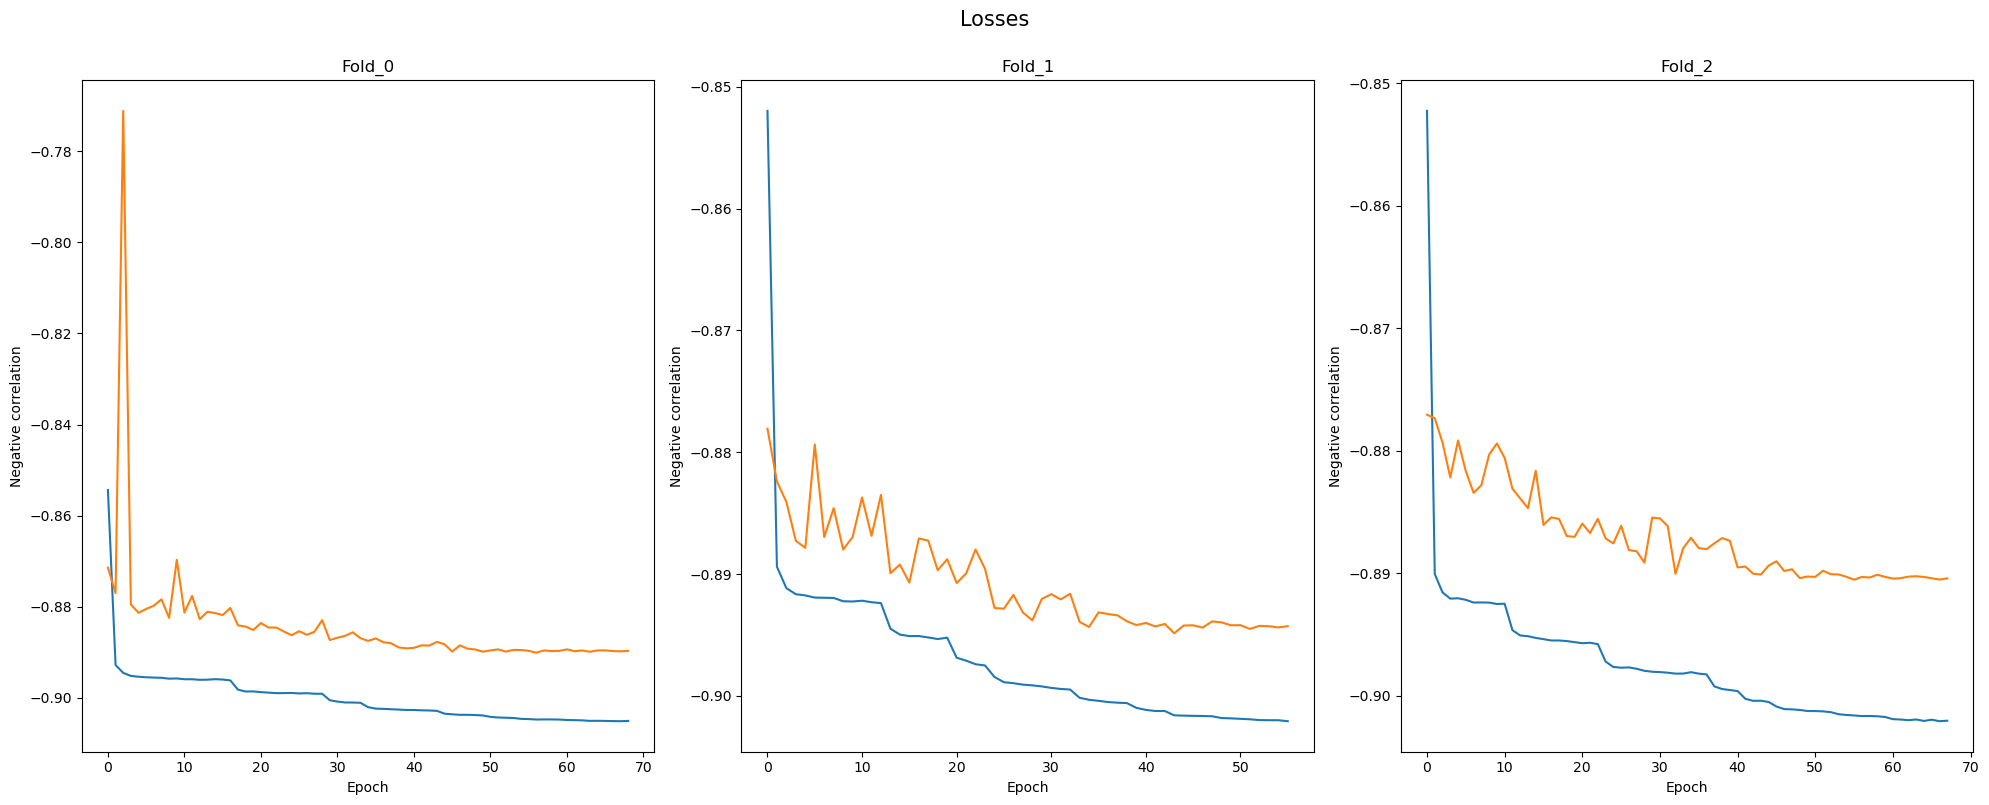

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
plt.suptitle('Losses', y=1, fontsize=15)
for i in range(3):
    axes[i].plot(histories[i].history['loss'], label='train_loss')
    axes[i].plot(histories[i].history['val_loss'], label='val_loss')
    axes[i].set(xlabel='Epoch', ylabel='Negative correlation', title=f"Fold_{i}")
plt.tight_layout()
plt.show()

## Submit

In [14]:
if SUBMIT:
    test_pred = np.zeros((len(X_test), 140), dtype=np.float32)
    for fold in range(3):
        print(f"Predicting with fold {fold}")
        model = load_model(f"/kaggle/temp1/model_{fold}",
                           custom_objects={
                               'negative_correlation_loss':
                               negative_correlation_loss
                           })
        test_pred += model.predict(X_test)
    np.save('test_preds.npy', test_pred)

Predicting with fold 0
1521/1521 [==============================] - 4s 2ms/step
Predicting with fold 1
1521/1521 [==============================] - 4s 2ms/step
Predicting with fold 2
1521/1521 [==============================] - 4s 2ms/step
